In [18]:
#!pip install ydata-synthetic
#https://colab.research.google.com/github/ydataai/ydata-synthetic/blob/master/examples/timeseries/TimeGAN_Synthetic_stock_data.ipynb#scrollTo=tw63DsLXhfYo

In [19]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeSeriesSynthesizer

In [20]:
# Specific to TimeGANs
seq_len = 24
n_seq = 1
hidden_dim = 24
gamma = 1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4
# For quick prototyping
# epochs=50000
epochs = 2000

gan_args = ModelParameters(
    batch_size=batch_size, lr=learning_rate, noise_dim=noise_dim, layers_dim=dim
)

train_args = TrainParameters(
    epochs=epochs, sequence_length=seq_len, number_sequences=n_seq
)

In [21]:
wti_df = pd.read_csv('../data/wti_prices.csv', index_col=0, parse_dates=['Date'])
cols = list(wti_df.columns)
print(wti_df.shape)
print(cols)

(481, 1)
['WTI_price']


In [22]:
wti_df = np.log(wti_df).diff().dropna()

In [23]:

synth = TimeSeriesSynthesizer(modelname="timegan", model_parameters=gan_args)
synth.fit(wti_df, train_args, num_cols=cols)
synth.save("synthesizer_wti.pkl")

A DataProcessor is not available for the TimeGAN.


Joint networks training: 100%|██████████| 2000/2000 [1:39:18<00:00,  2.98s/it]
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:486: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [24]:
stock_data_blocks = processed_stock(path='../data/wti_prices.csv', seq_len=seq_len)
synth_data = np.asarray(synth.sample(len(stock_data_blocks)))
print(synth_data.shape)

(457, 24, 1)


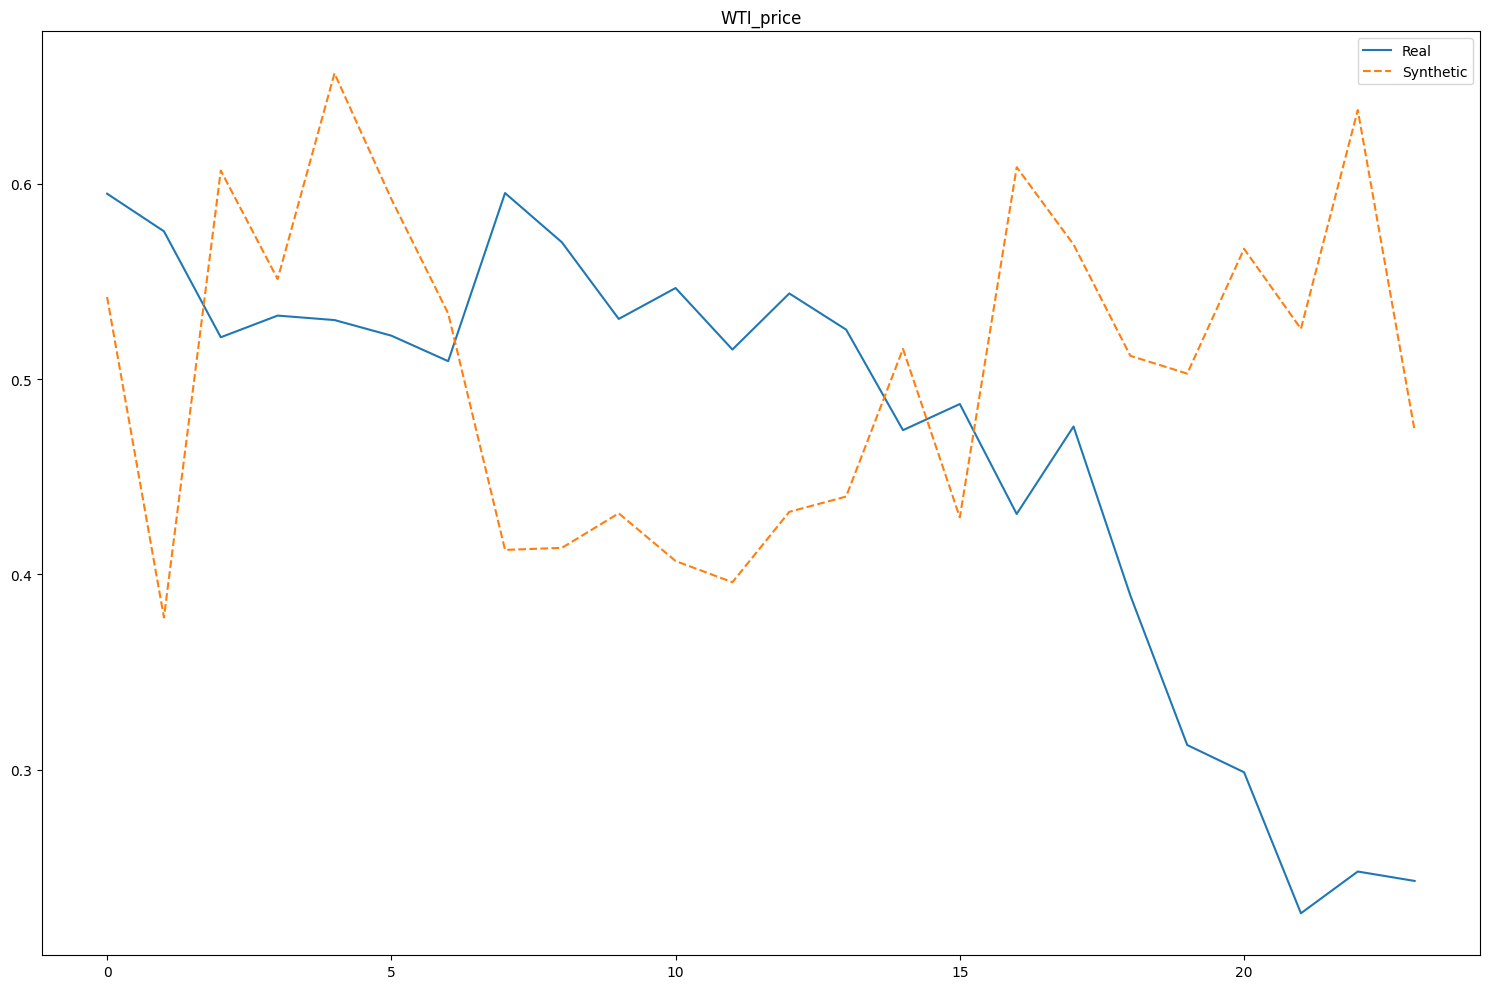

In [25]:
#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(figsize=(15, 10))

time = list(range(1,25))
obs = np.random.randint(len(stock_data_blocks))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data_blocks[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes,
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 100
idx = np.random.permutation(len(stock_data_blocks))[:sample_size]

real_sample = np.asarray(stock_data_blocks)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

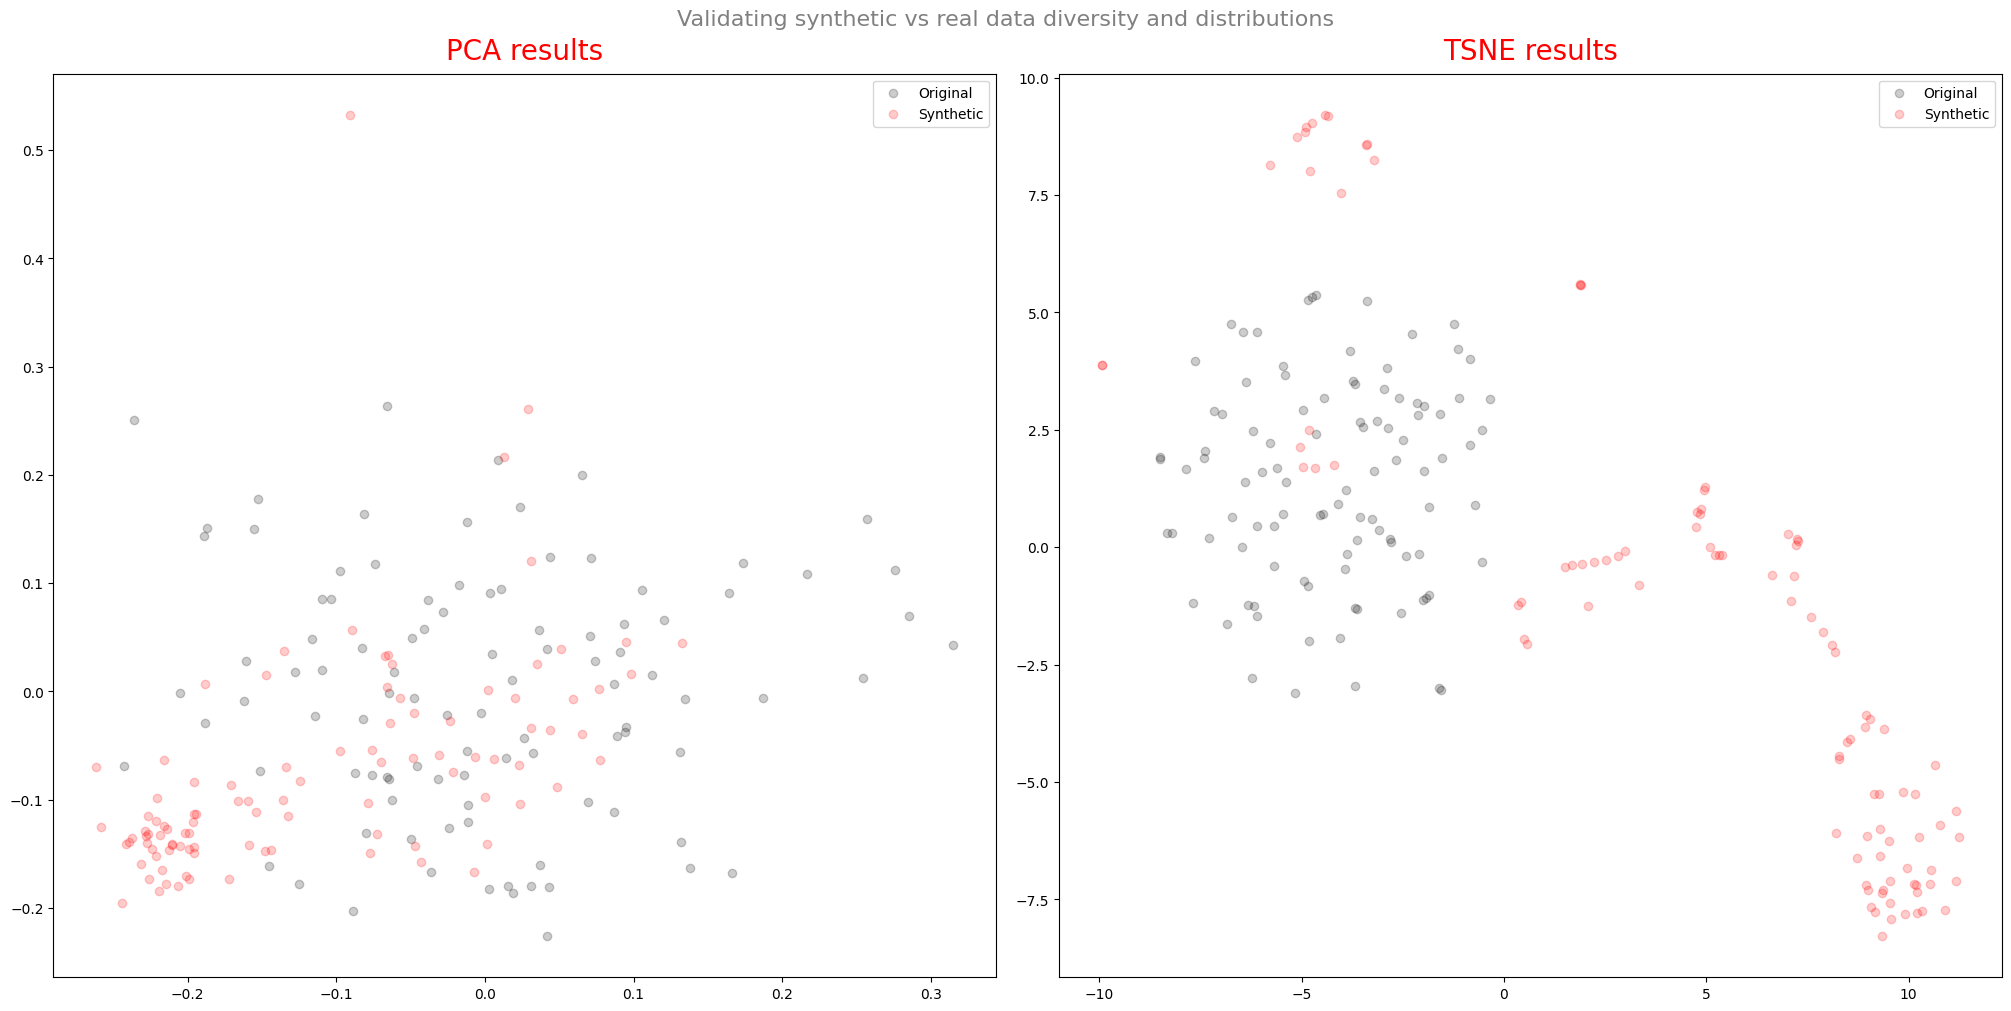

In [27]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')